### Imports

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Fetch Data

In [13]:
directory="./dataset_binary"

In [14]:
batch_size = 16
img_height = 180
img_width = 180

tf.keras.preprocessing.image_dataset_from_directory kullanarak görüntü veri kümemizi direkt olarak herhangi bir dizinden okutabiliriz. Bu fonksiyon dizindeki görüntü dosyalarından bir tf.data.Dataset oluşturur.

Bu fonksiyon ile desteklenen resim formatları: jpeg, png, bmp, gif’dir. Animasyonlu gifler ilk kareye kesilir.

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

FileNotFoundError: [WinError 3] Sistem belirtilen yolu bulamıyor: './dataset_binary'

In [117]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1081 files belonging to 3 classes.
Using 216 files for validation.


Bu tf.data.Dataset nesnesi her seferinde 32 tane (180 x 180) boyutlu görüntüyü size geri döndürecektir çünkü batch_size = 32 olarak ayarlanmıştır.

In [118]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 180, 180, 3)
(16,)


In [119]:
train_ds.class_names

['diger', 'nesih', 'rika']

Veri kümesini Görüntüleyelim:

Burada .take(1) alındığı için 1 adet 32 büyüklüğünde yığın seçilecektir.

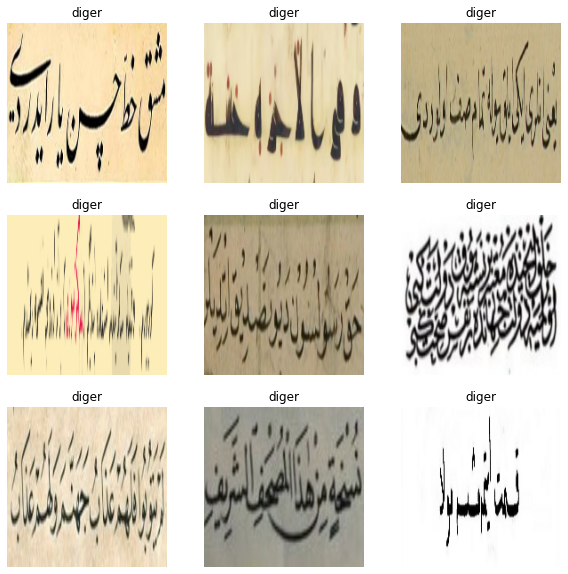

In [120]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")

### Training

In [121]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [122]:
normalization_layer = layers.Rescaling(1./255)

In [123]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.7886488


In [124]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [125]:
num_classes = 3

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

data augmentation:görüntü verisi çeşitlendirme

In [126]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [127]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_12 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_13 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 45, 45, 64)      

In [128]:
epochs=90
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/90
55/55 [==============================] - 11s 195ms/step - loss: 1.3853 - accuracy: 0.4555 - val_loss: 0.9311 - val_accuracy: 0.5370
Epoch 2/90
55/55 [==============================] - 11s 194ms/step - loss: 1.0041 - accuracy: 0.4728 - val_loss: 1.0208 - val_accuracy: 0.5046
Epoch 3/90
55/55 [==============================] - 11s 200ms/step - loss: 0.9625 - accuracy: 0.5064 - val_loss: 0.7814 - val_accuracy: 0.6250
Epoch 4/90
55/55 [==============================] - 11s 198ms/step - loss: 0.8488 - accuracy: 0.5723 - val_loss: 0.7804 - val_accuracy: 0.6435
Epoch 5/90
55/55 [==============================] - 11s 203ms/step - loss: 0.7809 - accuracy: 0.6162 - val_loss: 0.8781 - val_accuracy: 0.6250
Epoch 6/90
55/55 [==============================] - 11s 197ms/step - loss: 0.7772 - accuracy: 0.6173 - val_loss: 0.7872 - val_accuracy: 0.6620
Epoch 7/90
55/55 [==============================] - 11s 192ms/step - loss: 0.7120 - accuracy: 0.6647 - val_loss: 0.7526 - val_accuracy: 0.6481

Epoch 58/90
55/55 [==============================] - 12s 209ms/step - loss: 0.1811 - accuracy: 0.9295 - val_loss: 0.4998 - val_accuracy: 0.9074
Epoch 59/90
55/55 [==============================] - 11s 206ms/step - loss: 0.1694 - accuracy: 0.9422 - val_loss: 0.3304 - val_accuracy: 0.8981
Epoch 60/90
55/55 [==============================] - 11s 204ms/step - loss: 0.1574 - accuracy: 0.9491 - val_loss: 0.3702 - val_accuracy: 0.8981
Epoch 61/90
55/55 [==============================] - 11s 208ms/step - loss: 0.1363 - accuracy: 0.9538 - val_loss: 0.4870 - val_accuracy: 0.8750
Epoch 62/90
55/55 [==============================] - 11s 205ms/step - loss: 0.1420 - accuracy: 0.9434 - val_loss: 0.4951 - val_accuracy: 0.8796
Epoch 63/90
55/55 [==============================] - 11s 208ms/step - loss: 0.1503 - accuracy: 0.9387 - val_loss: 0.4523 - val_accuracy: 0.9028
Epoch 64/90
55/55 [==============================] - 12s 213ms/step - loss: 0.1410 - accuracy: 0.9434 - val_loss: 0.3391 - val_accuracy:

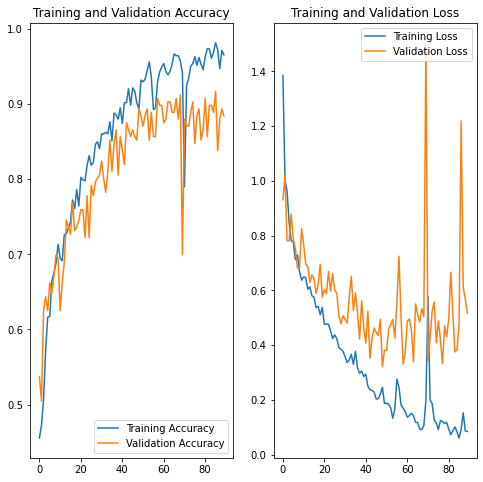

In [129]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict

In [8]:
import os

directoryLabel="./test_binary"
os.chdir(directoryLabel)
testLabels=os.listdir()

for label in testLabels:
    directoryData="./test_binary/"+label+"/"
    accuracyCount=0
    dataCount=0

    os.chdir(directoryData)
    testData=os.listdir()

    for data in testData:
        dataCount=dataCount+1
       
        img = tf.keras.utils.load_img(
            data, target_size=(img_height, img_width)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)]==label:
            accuracyCount=accuracyCount+1
        #print("This image {} most likely belongs to {} with a {:.2f} percent confidence.".format(data,class_names[np.argmax(score)], 100 * np.max(score)))
        
    print("{} türünden {} tane veriden {} tanesi doğru tahmin edildi ".format(label,dataCount,accuracyCount))

FileNotFoundError: [WinError 2] Sistem belirtilen dosyayı bulamıyor: './test_binary'